In [2]:
% pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns
try:
    from moviepy.video.io.bindings import mplfig_to_npimage
    import moviepy.editor as mpy
    generate_movie = True
except:
    print("Warning: moviepy not found.")
    generate_movie = False

slim = tf.contrib.slim
ds = tf.contrib.distributions

Populating the interactive namespace from numpy and matplotlib


/home/houssam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
print(tf.__version__)

1.5.0



### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [4]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [5]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-4.5,4.5,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

In [6]:
def load_mnist_and_sample(batch_size):
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    from sampler import sampler
    
    im=mnist.train.next_batch(1)[0]
    im=im.reshape([28,28])
    
    x = np.linspace(0, 1, 28)
    y = np.linspace(0, 1,28)
    xv, yv = np.meshgrid(x, y)
    z=im
    s=sampler(x,y,z)
    vals = s.sample(batch_size)
    
    return vals,im
    
def plot_vals_im(vals,im):
    xVals = []; yVals = []
    fig, ax = plt.subplots(nrows=1, ncols=2)
    for item in vals:  # plot point by point
            xVals.append(item[0])
            yVals.append(item[1])
            ax[0].plot(item[0], 1-item[1], marker="x", c="red")
            ax[0].set_title('Complex distribution')
    
    ax[1].imshow(im,cmap='gray')
    ax[1].set_title('Original Image')
    plt.show()

def sample_complex(batch_size):
    vals, im = load_mnist_and_sample(batch_size)
    plot_vals_im(vals,im)
    
    return tf.stack(vals)

### Hyperparam

In [7]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-4,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=20000,
    frame_every=2000, 
    viz_every=2000,
    z_dim=256,
    x_dim=2,
    optimizer='rmsprop', # rmsprop sgd sga
    align = True,
    data = 'mog',
    LAMBDA = 10
)

## Function for Symplectic gradient adjustment

In [8]:
def jac_vec(ys,xs,vs):
    return fwd_gradients(ys,xs,grad_xs=vs, stop_gradients=xs)

def jac_tran_vec(ys,xs,vs):
    dydxs = tf.gradients(ys,xs,grad_ys=vs, stop_gradients=xs)
    return [tf.zeros_like(x) if dydx is None else dydx for (x,dydx) in zip(xs,dydxs)]

def get_sym_adj(Ls,xs):
    xi= [tf.gradients(l,x)[0]for(l,x)in zip(Ls,xs)]
    H_xi = jac_vec(xi,xs,xi)
    Ht_xi = jac_tran_vec(xi,xs,xi)
    At_xi =[(ht-h)/2 for (h,ht) in zip(H_xi,Ht_xi)]
    return At_xi

## Construct model and training ops

In [11]:
tf.reset_default_graph()

data = sample_complex(params['batch_size']) if params['data']=='complex' else sample_mog(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.4)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

loss_gen = -tf.reduce_mean(fake_score)
loss_dis = tf.reduce_mean(fake_score) - tf.reduce_mean(real_score)

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")


if MODE == 'wgan':

    d_train_opt = tf.train.RMSPropOptimizer(params['gen_learning_rate'])
    g_train_opt = tf.train.RMSPropOptimizer(params['disc_learning_rate'])
    d_train_op = d_train_opt.minimize(loss_dis, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(loss_gen, var_list=gen_vars)

    clip_ops = []
    for var in disc_vars:
        clip_bounds = [-.01, .01]
        clip_ops.append(
            tf.assign(
                var, 
                tf.clip_by_value(var, clip_bounds[0], clip_bounds[1])
            )
        )
    clip_disc_weights = tf.group(*clip_ops)

elif MODE == 'wgan-gp':
    fake_data = samples
    real_data = data

    # Gradient penalty
    alpha = tf.random_uniform(
        shape=[params['batch_size'],1], 
        minval=0.,
        maxval=1.
    )
    differences = fake_data - real_data
    interpolates = real_data + (alpha*differences)
    gradients = tf.gradients(discriminator(interpolates,reuse=True), [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    disc_cost += params['LAMBDA']*gradient_penalty

    g_train_op = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9).minimize(loss_gen, var_list=gen_vars)
    d_train_op = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9).minimize(loss_dis, var_list=disc_vars)

[<tf.Tensor 'gradients/AddN_15:0' shape=(2, 384) dtype=float32>, <tf.Tensor 'gradients/AddN_14:0' shape=(384,) dtype=float32>, <tf.Tensor 'gradients/AddN_13:0' shape=(384, 384) dtype=float32>, <tf.Tensor 'gradients/AddN_12:0' shape=(384,) dtype=float32>, <tf.Tensor 'gradients/AddN_11:0' shape=(384, 384) dtype=float32>, <tf.Tensor 'gradients/AddN_10:0' shape=(384,) dtype=float32>, <tf.Tensor 'gradients/AddN_9:0' shape=(384, 384) dtype=float32>, <tf.Tensor 'gradients/AddN_8:0' shape=(384,) dtype=float32>, <tf.Tensor 'gradients/AddN_7:0' shape=(384, 384) dtype=float32>, <tf.Tensor 'gradients/AddN_6:0' shape=(384,) dtype=float32>, <tf.Tensor 'gradients/AddN_5:0' shape=(384, 384) dtype=float32>, <tf.Tensor 'gradients/AddN_4:0' shape=(384,) dtype=float32>, <tf.Tensor 'gradients/AddN_3:0' shape=(384, 1) dtype=float32>, <tf.Tensor 'gradients/AddN_2:0' shape=(1,) dtype=float32>, <tf.Tensor 'gradients_1/generator/Stack/fully_connected_1/MatMul_grad/tuple/control_dependency_1:0' shape=(256, 384) 

ValueError: Tensor("truediv:0", shape=(2, 384), dtype=float32) must be from the same graph as Tensor("Sign:0", shape=(), dtype=float32).

## Train

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/8001 [00:00<?, ?it/s]

1.0


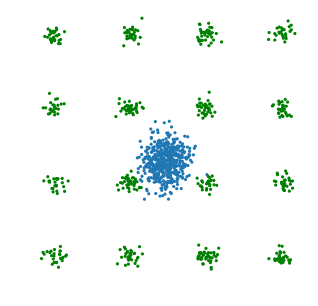

  1%|          | 99/8001 [00:13<12:17, 10.72it/s]  

1.0


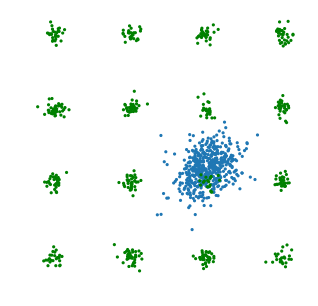

  2%|▏         | 199/8001 [00:23<12:00, 10.82it/s]

1.0


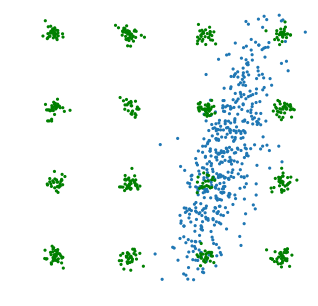

  4%|▎         | 299/8001 [00:32<11:52, 10.81it/s]

-1.0


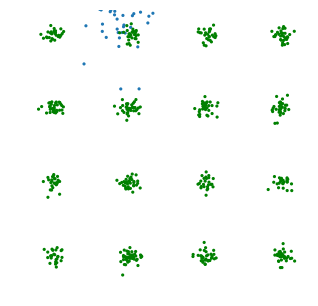

  5%|▍         | 399/8001 [00:42<11:42, 10.82it/s]

-1.0


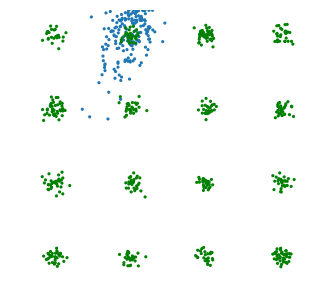

  6%|▌         | 499/8001 [00:51<11:33, 10.81it/s]

1.0


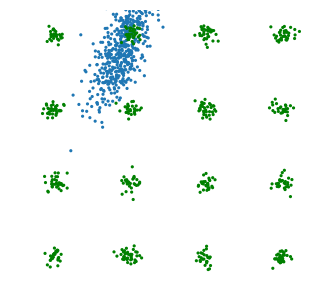

  7%|▋         | 599/8001 [01:01<11:31, 10.71it/s]

1.0


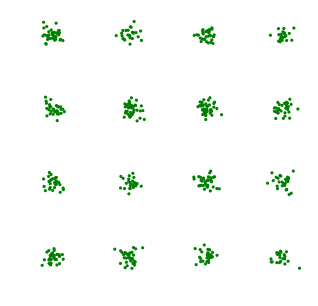

  9%|▊         | 699/8001 [01:10<11:16, 10.80it/s]

-1.0


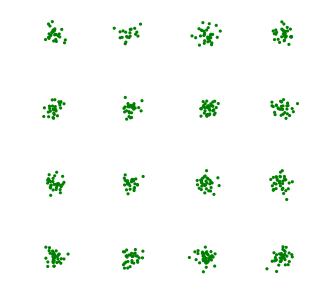

 10%|▉         | 799/8001 [01:19<11:07, 10.79it/s]

1.0


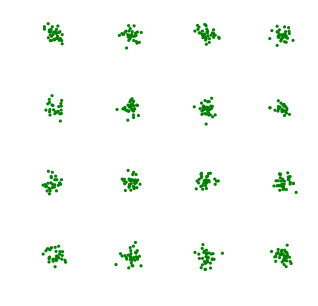

 11%|█         | 899/8001 [01:29<10:53, 10.87it/s]

-1.0


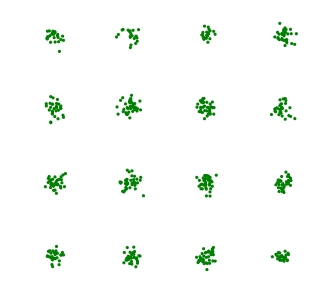

 12%|█▏        | 999/8001 [01:38<10:45, 10.85it/s]

-1.0


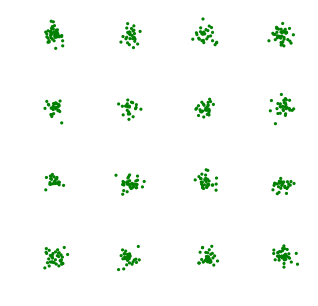

 14%|█▎        | 1099/8001 [01:48<10:35, 10.86it/s]

-1.0


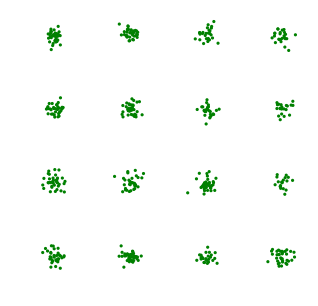

 15%|█▍        | 1199/8001 [01:57<10:28, 10.82it/s]

1.0


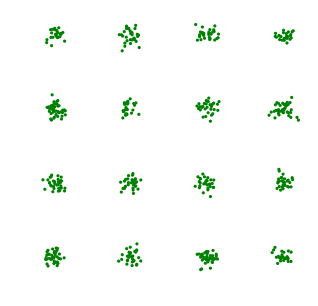

 16%|█▌        | 1299/8001 [02:07<10:20, 10.80it/s]

-1.0


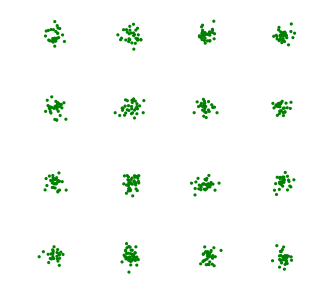

 17%|█▋        | 1399/8001 [02:16<10:13, 10.76it/s]

1.0


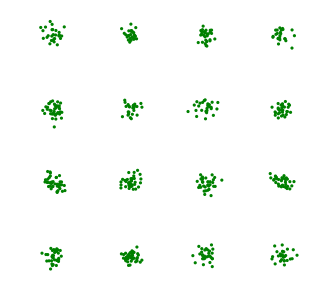

 19%|█▊        | 1499/8001 [02:25<10:02, 10.80it/s]

1.0


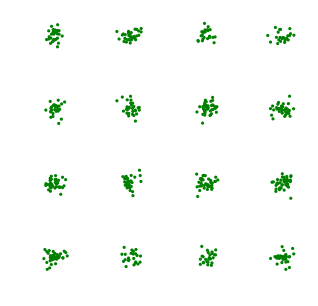

 20%|█▉        | 1599/8001 [02:35<09:54, 10.77it/s]

1.0


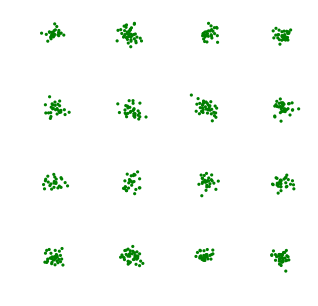

 21%|██        | 1699/8001 [02:44<09:42, 10.82it/s]

1.0


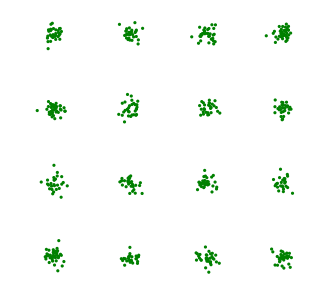

 22%|██▏       | 1799/8001 [02:54<09:36, 10.75it/s]

1.0


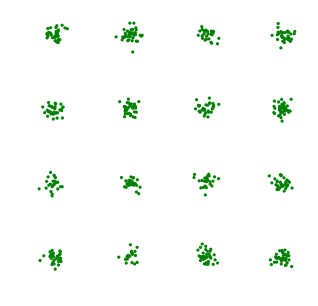

 24%|██▎       | 1899/8001 [03:04<09:26, 10.78it/s]

-1.0


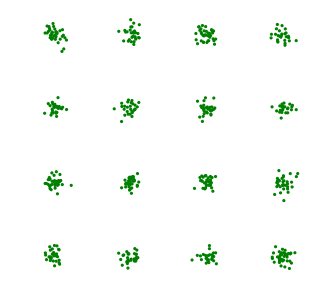

 25%|██▍       | 1999/8001 [03:13<09:20, 10.71it/s]

-1.0


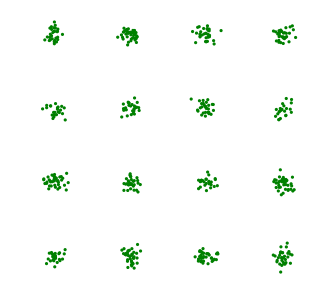

 26%|██▌       | 2099/8001 [03:23<09:13, 10.67it/s]

1.0


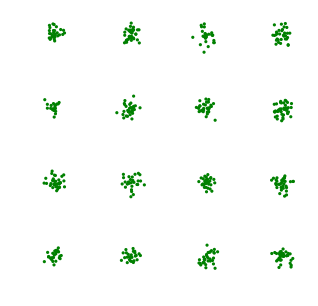

 27%|██▋       | 2199/8001 [03:32<09:05, 10.64it/s]

1.0


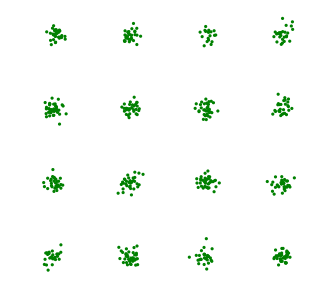

 29%|██▊       | 2299/8001 [03:42<08:49, 10.77it/s]

-1.0


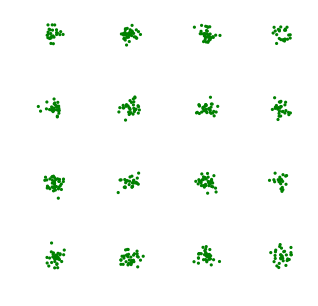

 30%|██▉       | 2399/8001 [03:51<08:45, 10.65it/s]

-1.0


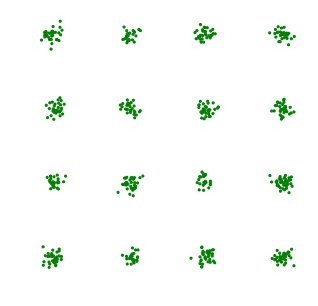

 31%|███       | 2499/8001 [04:01<08:29, 10.80it/s]

-1.0


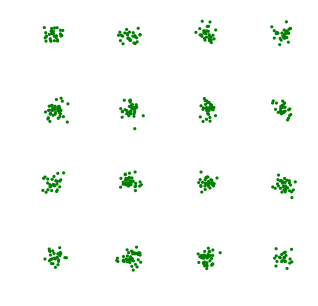

 32%|███▏      | 2599/8001 [04:10<08:19, 10.82it/s]

1.0


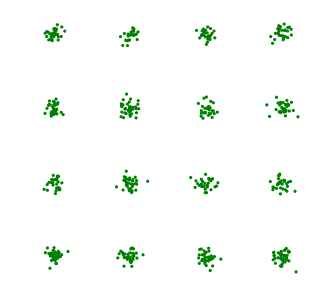

 34%|███▎      | 2699/8001 [04:20<08:09, 10.83it/s]

1.0


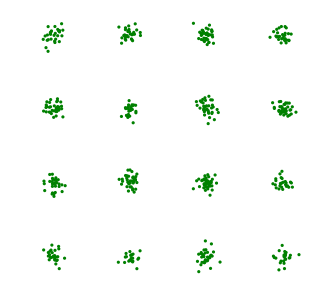

 35%|███▍      | 2799/8001 [04:29<08:02, 10.79it/s]

-1.0


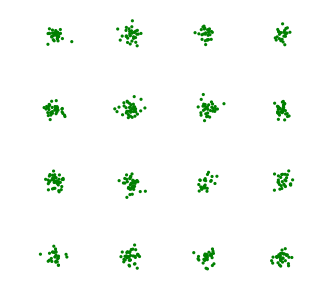

 36%|███▌      | 2899/8001 [04:39<07:54, 10.76it/s]

1.0


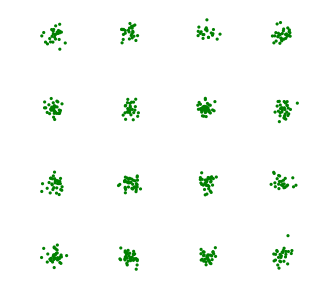

 37%|███▋      | 2999/8001 [04:48<07:42, 10.81it/s]

-1.0


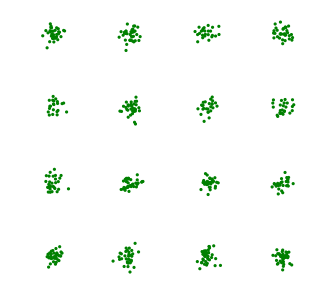

 39%|███▊      | 3099/8001 [04:58<07:32, 10.83it/s]

1.0


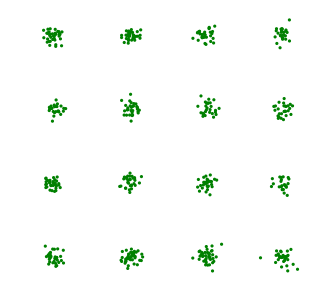

 40%|███▉      | 3199/8001 [05:07<07:25, 10.78it/s]

-1.0


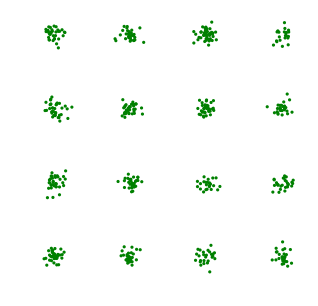

 41%|████      | 3289/8001 [05:16<07:23, 10.61it/s]

In [ ]:
xmax = 3
fs = []
raw_frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']
frame_every = params['frame_every']
for i in tqdm(range(params['max_iter']+1)):
    f, _, _ = sess.run([[loss], g_train_op, d_train_op])
    fs.append(f)
    if (i) % frame_every == 0:
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        print(sess.run(lambd))
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10)
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
        if params["data"]=="complex":
            plt.xlim([-0.2, 1.2])
            plt.ylim([-0.2, 1.2])
        else:
            plt.xlim([-5.5, 5.5])
            plt.ylim([-5.5, 5.5])
        axis('off')
        if generate_movie:
            raw_frames.append(mplfig_to_npimage(fig))
        if (i) % viz_every == 0:
            show()

In [ ]:
np_samples_ = np_samples[::1]
vizu_frames = []
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
# figure(figsize=(2*cols, 2))
fig, ax = plt.subplots()
for i, samps in enumerate(np_samples_):
    ax.clear()
#     if i == 0:
#         ax = subplot(1,cols,1)
#     else:
#         subplot(1,cols,i+1, sharex=ax, sharey=ax)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-6,6]]*2)
    ax2.set_axis_bgcolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%(i*frame_every))
    if generate_movie:
        vizu_frames.append(mplfig_to_npimage(fig))
gcf().tight_layout()

## Video maker

In [ ]:
raw_clip = mpy.ImageSequenceClip(raw_frames[::], fps=10)
raw_clip.write_videofile("raw_optimizer{}_{}.webm".format(params['optimizer'], params['data']), audio=False)
vizu_clip = mpy.ImageSequenceClip(vizu_frames[::], fps=10)
vizu_clip.write_videofile("vizu_optimizer{}_{}.webm".format(params['optimizer'], params['data']), audio=False)